## Atividade 06
Com base no código da LeNet apresentado durante a aula, modifique-o para que a rede seja treinada utilizando a função de ativação ReLu e não mais utilizando Sigmoid e TanH. Algumas observações:

1. É preciso alterar também a taxa de aprendizagem.
2. Avalie os resultados utilizando o tensorboard.

Compare o aprendizado entre o treinamento utilizando ReLu e o treinamento utilizando o Sigmoid + TanH. A análise pode ser qualitativa observando os gráficos, ou quantitativa medindo o número de épocas necessárias para ter acurácia 98% no teste.

Altere o dataset para o Cifar10 e veja o comportamento da rede ao utilizar um dataset mais desafiador.

# Dados

## Caminhos

In [1]:
datasets_path     = 'ap5/datasets/'
models_path       = 'ap5/models/'
tensorboard_path  = 'ap5/Tensorboard/lenet5/'

## Dataloader

In [3]:
from torch.utils.data import DataLoader
import torchvision

import matplotlib.pyplot as plt
import numpy as np

def my_imshow(img, dataset, numImages=10):
    print(img.shape)
    if dataset == 'cifar10' : 
        img = img / 2 + 0.5     # unnormalize
    
    img = torchvision.utils.make_grid(img[:numImages],nrow=numImages//2)
    
    npimg = img.numpy()    
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.axis('off')
    plt.imshow(npimg)
    plt.show()

def show_images(train_loader, test_loader, dataset, numImages=10) :
    print('Train samples')
    # get some random training images
    dataiter = iter(train_loader)
    images = dataiter.next()[0]
    my_imshow(images, dataset, numImages)

    print('Test samples')
    # get some random training images
    dataiter = iter(test_loader)
    images = dataiter.next()[0]
    my_imshow(images, dataset, numImages)

def get_data_cifar10 ( batch_size , show_image=False, numImages=10 ) :
  
    my_transform = torchvision.transforms.Compose([
                            torchvision.transforms.Resize(28),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(mean=[0.5],std=[0.5]) #na hora de testar tem que 
                                    ])                            #normalizar os dados dessa EXATA forma

    train_dataset = torchvision.datasets.CIFAR10(
                                root=f'{datasets_path}/train/', 
                                train=True, 
                                transform=my_transform, 
                                download=False
                                )
    test_dataset = torchvision.datasets.CIFAR10(
                                root=f'{datasets_path}/test/',
                                train=False, 
                                transform=my_transform, 
                                download=False
                                )
    train_loader = DataLoader(train_dataset, 
                                batch_size=batch_size,
                                shuffle=True
                                )
    test_loader = DataLoader(test_dataset, 
                            batch_size=batch_size,
                            shuffle=False
                            )
    
    if show_image :
        show_images(train_loader, test_loader, 'cifar10', numImages)
    
    return train_loader, test_loader, len(train_dataset)


def get_data_mnist ( batch_size , show_image=False, numImages=10 ) :
  
    train_dataset = torchvision.datasets.mnist.MNIST(
                            root=f'{datasets_path}/train/', 
                            train=True, 
                            transform=torchvision.transforms.ToTensor(), 
                            download=False
                            )
    test_dataset = torchvision.datasets.mnist.MNIST(
                            root=f'{datasets_path}/test/',
                            train=False, 
                            transform=torchvision.transforms.ToTensor(), 
                            download=False
                            )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    if show_image :
        show_images(train_loader, test_loader, 'mnist', numImages)
    
    return train_loader, test_loader, len(train_dataset)

Train samples


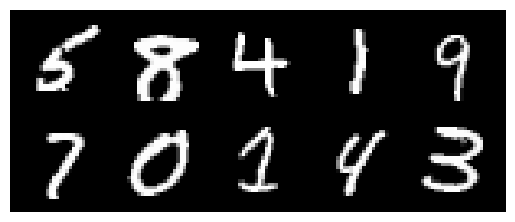

Test samples


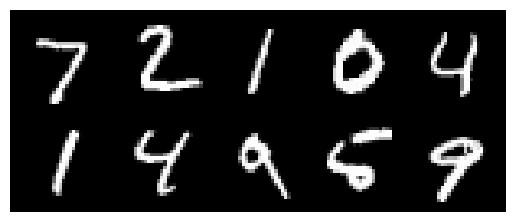

In [4]:
get_data_mnist(batch_size=256, show_image=True, numImages=10);

Train samples


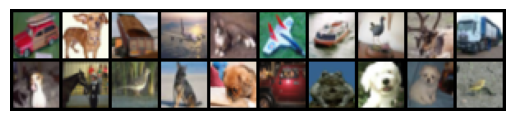

Test samples


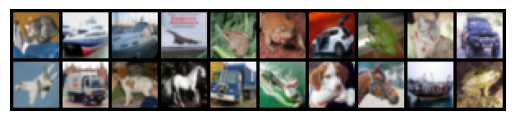

In [5]:
get_data_cifar10(batch_size=256, show_image=True, numImages=20);

# Rede

## Arquitetura

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module) :
  
    def __init__(self, num_classes=10, n_channels=1):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=n_channels, out_channels=6, 
                            kernel_size=(5,5), padding=2, stride=1)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.activationS2 = nn.ReLU()
        #self.activationS2 = nn.Sigmoid()
        
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, 
                            kernel_size=(5,5), padding=0, stride=1)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.activationS4 = nn.ReLU()
        #self.activationS4 = nn.Sigmoid()
        
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, 
                            kernel_size=(5,5), padding=0, stride=1)
        self.activationC5 = nn.ReLU()
        #self.activationC5 = nn.Sigmoid()
        
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.activationF6 = nn.ReLU()
        #self.activationF6 = nn.Tanh()
        
        self.f = nn.Linear(in_features=84, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, debug=False):
        # Convolutional
        if debug : print('Input',x.shape)
        y = self.c1(x)
        if debug : print('Outputs:')
        if debug : print('C1',y.shape)
        y = self.s2(y)
        if debug : print('S2',y.shape)
        y = self.activationS2(y)
        if debug : print('Activation S2',y.shape)
        y = self.c3(y)
        if debug : print('C3',y.shape)
        y = self.s4(y)
        if debug : print('S4',y.shape)
        y = self.activationS4(y)
        if debug : print('Activation S4',y.shape)
        # Flattening
        y = self.c5(y)
        if debug : print('C5',y.shape)
        y = self.activationC5(y)
        if debug : print('Activation C5',y.shape)
        y = y.view(y.shape[0], -1)
        if debug : print('Reshape C5',y.shape)
        # Fully Connected
        y = self.f6(y)
        if debug : print('F6',y.shape)
        y = self.activationF6(y)
        if debug : print('Activation F6',y.shape)
        y = self.f(y)
        if debug : print('F',y.shape)
        s = self.softmax(y)
        if debug : print('Softamx',s.shape)
        return y, s

## Informações sobre a rede

In [7]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
    
print(f"Running on {my_device.type}.")

net = LeNet(num_classes=10, n_channels=3)
net = net.to(my_device)

a = torch.rand( (1, 3, 28, 28) ) #(num_batches, num_channels, x, y)

b = net( a.to(my_device) , debug=True )

Running on cuda.
Input torch.Size([1, 3, 28, 28])
Outputs:
C1 torch.Size([1, 6, 28, 28])
S2 torch.Size([1, 6, 14, 14])
Activation S2 torch.Size([1, 6, 14, 14])
C3 torch.Size([1, 16, 10, 10])
S4 torch.Size([1, 16, 5, 5])
Activation S4 torch.Size([1, 16, 5, 5])
C5 torch.Size([1, 120, 1, 1])
Activation C5 torch.Size([1, 120, 1, 1])
Reshape C5 torch.Size([1, 120])
F6 torch.Size([1, 84])
Activation F6 torch.Size([1, 84])
F torch.Size([1, 10])
Softamx torch.Size([1, 10])


In [8]:
from torchsummary import summary
summary(net, input_size=(3,28,28), batch_size=256)
del net, a, b

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─AvgPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            2,416
├─AvgPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Conv2d: 1-7                            48,120
├─ReLU: 1-8                              --
├─Linear: 1-9                            10,164
├─ReLU: 1-10                             --
├─Linear: 1-11                           850
├─Softmax: 1-12                          --
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0


## Treinamento

In [9]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import copy
  
from datetime import datetime

def train ( dataset, epochs=100, lr=1e-1, prefix='', upper_bound=99.0, device='cpu',
           save=False, debug=False, plot_histograms=False, lambda_reg=0) :

    if dataset == 'mnist' :
        batch_size = 256
        train_loader, test_loader, dataset_size = get_data_mnist(batch_size, 
                                                                    show_image=True
                                                                    )
        num_classes = 10
        n_channels = 1
    elif dataset == 'cifar10' :
        batch_size = 256
        train_loader, test_loader, dataset_size = get_data_cifar10(batch_size, 
                                                                    show_image=True
                                                                    )
        num_classes = 10
        n_channels = 3
    else :
        print('Dataset loader not implemented.')
        return None    
  
    net = LeNet( num_classes, n_channels )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr, weight_decay=lambda_reg)
    loss = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = prefix + '-' + suffix if prefix != '' else suffix

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    writer.add_graph(net, next(iter(train_loader))[0].to(my_device))

    accuracies = []
    max_accuracy = -1.0

    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        net.train()  
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            optimizer.zero_grad()

            predict_y = net( train_x )[0]

            # Loss:
            error = loss( predict_y , train_label.long() )

            writer.add_scalar( 'Loss/train', error, 
                            idx+( epoch*(dataset_size//batch_size) ) )

            error.backward()
            optimizer.step()

            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                            idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print(f'idx: {idx}, _error: {error}')

        if plot_histograms : 
            plot_histograms_tensorboard(writer, net, epoch)
        
        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy.cpu()) #tava dando erro no plt.plot(accuracies) falando  
                            #"can't convert cuda:0 device type tensor to numpy.", imaginei que fosse isso e funcionou
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
    
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print(f'Saving Best Model with Accuracy: {max_accuracy:3.4f}')
            
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:3.4f}%' )

        if accuracy > upper_bound :
            break
   
    if save : 
        path = f'{models_path}LeNet5-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model.state_dict(), path)
        print('Model saved in:',path)
  
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model

In [10]:
def plot_histograms_tensorboard ( writer, net, epoch ) :
    writer.add_histogram('Bias/conv1',   net.c1.bias,        epoch)
    writer.add_histogram('Weight/conv1', net.c1.weight,      epoch)
    writer.add_histogram('Grad/conv1',   net.c1.weight.grad, epoch)

    writer.add_histogram('Bias/conv3',   net.c3.bias,        epoch)
    writer.add_histogram('Weight/conv3', net.c3.weight,      epoch)
    writer.add_histogram('Grad/conv3',   net.c3.weight.grad, epoch)

    writer.add_histogram('Bias/conv5',   net.c5.bias,        epoch)
    writer.add_histogram('Weight/conv5', net.c5.weight,      epoch)
    writer.add_histogram('Grad/conv5',   net.c5.weight.grad, epoch)

## Validação

In [11]:
def validate ( model , data , device='cpu') :
    model.eval()
    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x )[0].detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
    
    return correct*100./sum

# Execução

## Treina

Running on cuda.
Train samples


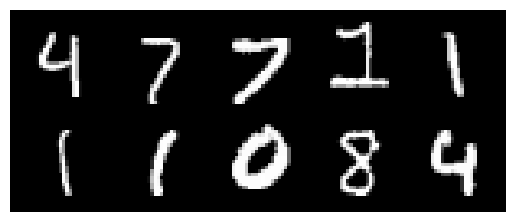

Test samples


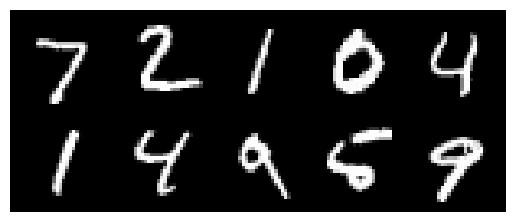

Training epochs...:  10%|█████████████████████▊                                                                                                                                                                                                    | 1/10 [00:06<00:59,  6.61s/it]

Saving Best Model with Accuracy: 9.8000
Epoch:   1 | Accuracy : 9.8000%


Training epochs...:  20%|███████████████████████████████████████████▌                                                                                                                                                                              | 2/10 [00:13<00:52,  6.59s/it]

Saving Best Model with Accuracy: 11.3500
Epoch:   2 | Accuracy : 11.3500%


Training epochs...:  30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3/10 [00:19<00:46,  6.69s/it]

Epoch:   3 | Accuracy : 11.3500%


Training epochs...:  40%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 4/10 [00:26<00:39,  6.62s/it]

Epoch:   4 | Accuracy : 11.3500%


Training epochs...:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 5/10 [00:33<00:32,  6.60s/it]

Epoch:   5 | Accuracy : 11.3500%


Training epochs...:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 6/10 [00:39<00:26,  6.61s/it]

Saving Best Model with Accuracy: 86.7500
Epoch:   6 | Accuracy : 86.7500%


Training epochs...:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7/10 [00:46<00:19,  6.60s/it]

Saving Best Model with Accuracy: 90.6100
Epoch:   7 | Accuracy : 90.6100%


Training epochs...:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8/10 [00:52<00:13,  6.56s/it]

Saving Best Model with Accuracy: 95.2100
Epoch:   8 | Accuracy : 95.2100%


Training epochs...:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9/10 [00:59<00:06,  6.56s/it]

Epoch:   9 | Accuracy : 94.7200%


Training epochs...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.61s/it]

Saving Best Model with Accuracy: 96.1400
Epoch:  10 | Accuracy : 96.1400%
Model saved in: ap5/models/LeNet5-mnist-96.14.pkl


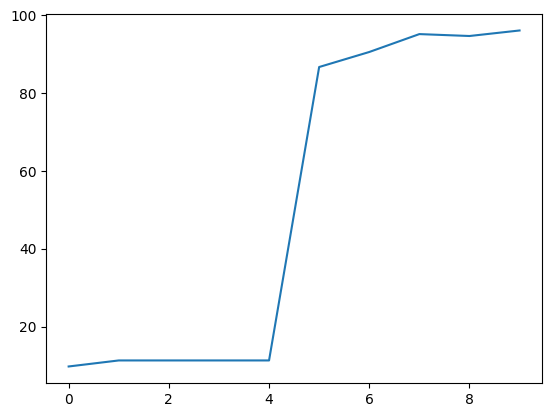

In [85]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
print(f"Running on {my_device.type}.")

epochs = 10
dataset = 'mnist'
# dataset = 'cifar10' 
lr = 1.3e0
lambda_reg = 1e-4

prefix = 'LeNet-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train( dataset=dataset, epochs=epochs, lr=lr, prefix=prefix , upper_bound=100, device=my_device,
            save=True, debug=False, plot_histograms=True, lambda_reg=lambda_reg )

With sigmoid and tanH functions, we reach 92.62% in epoch 10


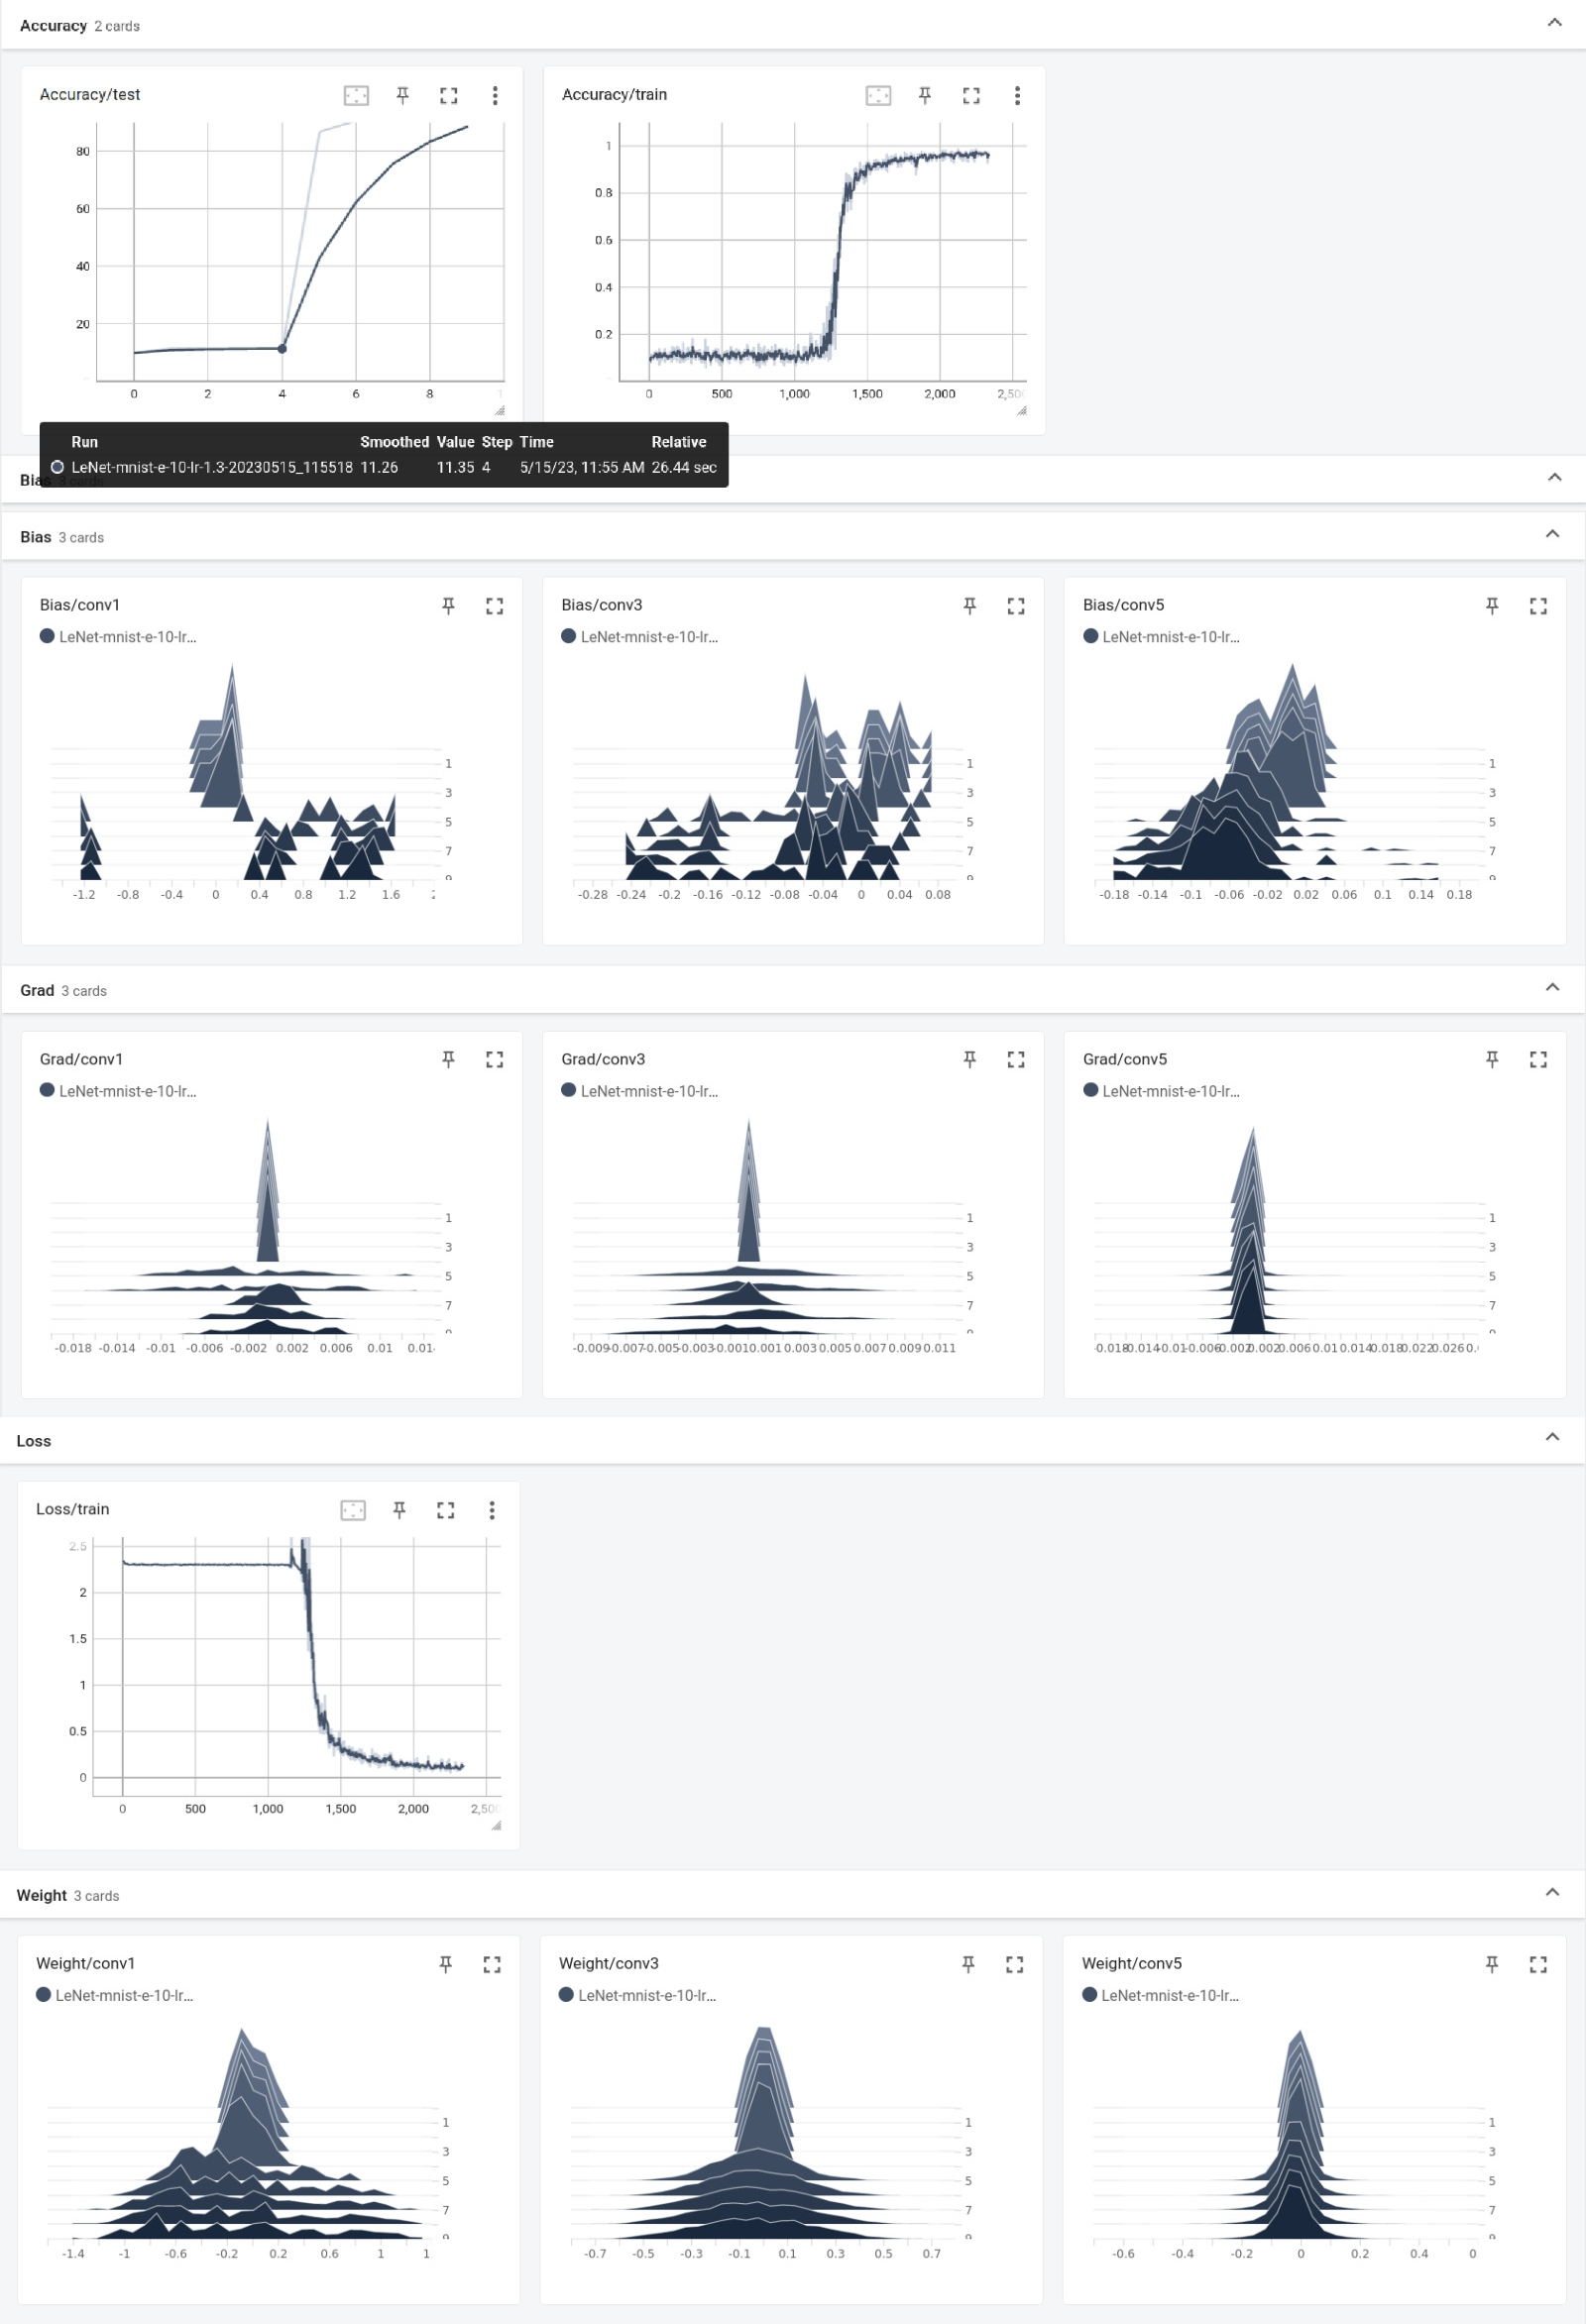

In [86]:
from PIL import Image
print("With sigmoid and tanH functions, we reach 92.62% in epoch 10")
image = Image.open("images/sigmoid_mnist.jpg")
image.show()

## Train MNIST (RELU)

Running on cuda.
Train samples


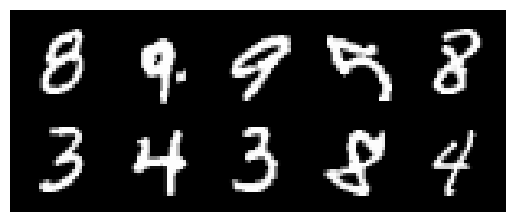

Test samples


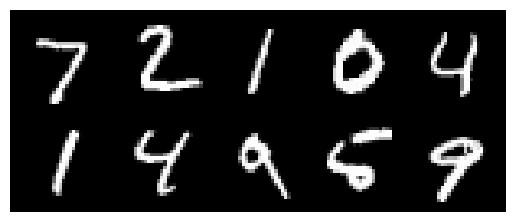

Training epochs...:  10%|██▍                     | 1/10 [00:17<02:38, 17.56s/it]

Saving Best Model with Accuracy: 75.3000
Epoch:   1 | Accuracy : 75.3000%


Training epochs...:  20%|████▊                   | 2/10 [00:35<02:20, 17.50s/it]

Saving Best Model with Accuracy: 94.1300
Epoch:   2 | Accuracy : 94.1300%


Training epochs...:  30%|███████▏                | 3/10 [00:52<02:03, 17.58s/it]

Saving Best Model with Accuracy: 94.5200
Epoch:   3 | Accuracy : 94.5200%


Training epochs...:  40%|█████████▌              | 4/10 [01:10<01:46, 17.68s/it]

Saving Best Model with Accuracy: 95.7100
Epoch:   4 | Accuracy : 95.7100%


Training epochs...:  50%|████████████            | 5/10 [01:28<01:28, 17.62s/it]

Saving Best Model with Accuracy: 96.6500
Epoch:   5 | Accuracy : 96.6500%


Training epochs...:  60%|██████████████▍         | 6/10 [01:45<01:10, 17.55s/it]

Saving Best Model with Accuracy: 97.2700
Epoch:   6 | Accuracy : 97.2700%


Training epochs...:  70%|████████████████▊       | 7/10 [02:03<00:52, 17.63s/it]

Epoch:   7 | Accuracy : 96.1400%


Training epochs...:  80%|███████████████████▏    | 8/10 [02:21<00:35, 17.71s/it]

Saving Best Model with Accuracy: 97.4800
Epoch:   8 | Accuracy : 97.4800%


Training epochs...:  90%|█████████████████████▌  | 9/10 [02:38<00:17, 17.75s/it]

Epoch:   9 | Accuracy : 97.4200%


Training epochs...: 100%|███████████████████████| 10/10 [02:56<00:00, 17.68s/it]

Saving Best Model with Accuracy: 97.8500
Epoch:  10 | Accuracy : 97.8500%
Model saved in: ap5/models/LeNet5-mnist-97.85.pkl


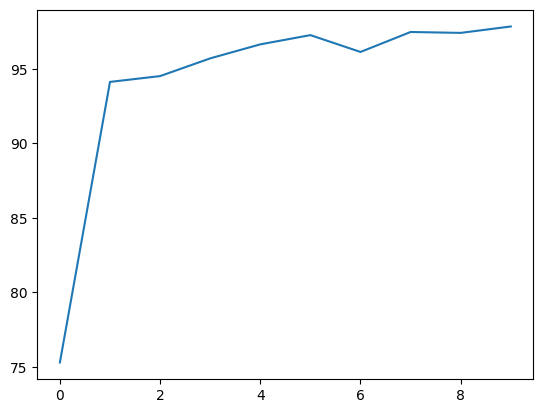

In [12]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
print(f"Running on {my_device.type}.")

epochs = 10
dataset = 'mnist'
# dataset = 'cifar10' 
#lr = 1.3e0
lambda_reg = 1e-4

lr = 1.3e-1

prefix = 'LeNet-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train( dataset=dataset, epochs=epochs, lr=lr, prefix=prefix , upper_bound=100, device=my_device,
            save=True, debug=False, plot_histograms=True, lambda_reg=lambda_reg )

With ReLu functions and using learning rate of 1.3e-1, we reach 97.42% in epoch 10 


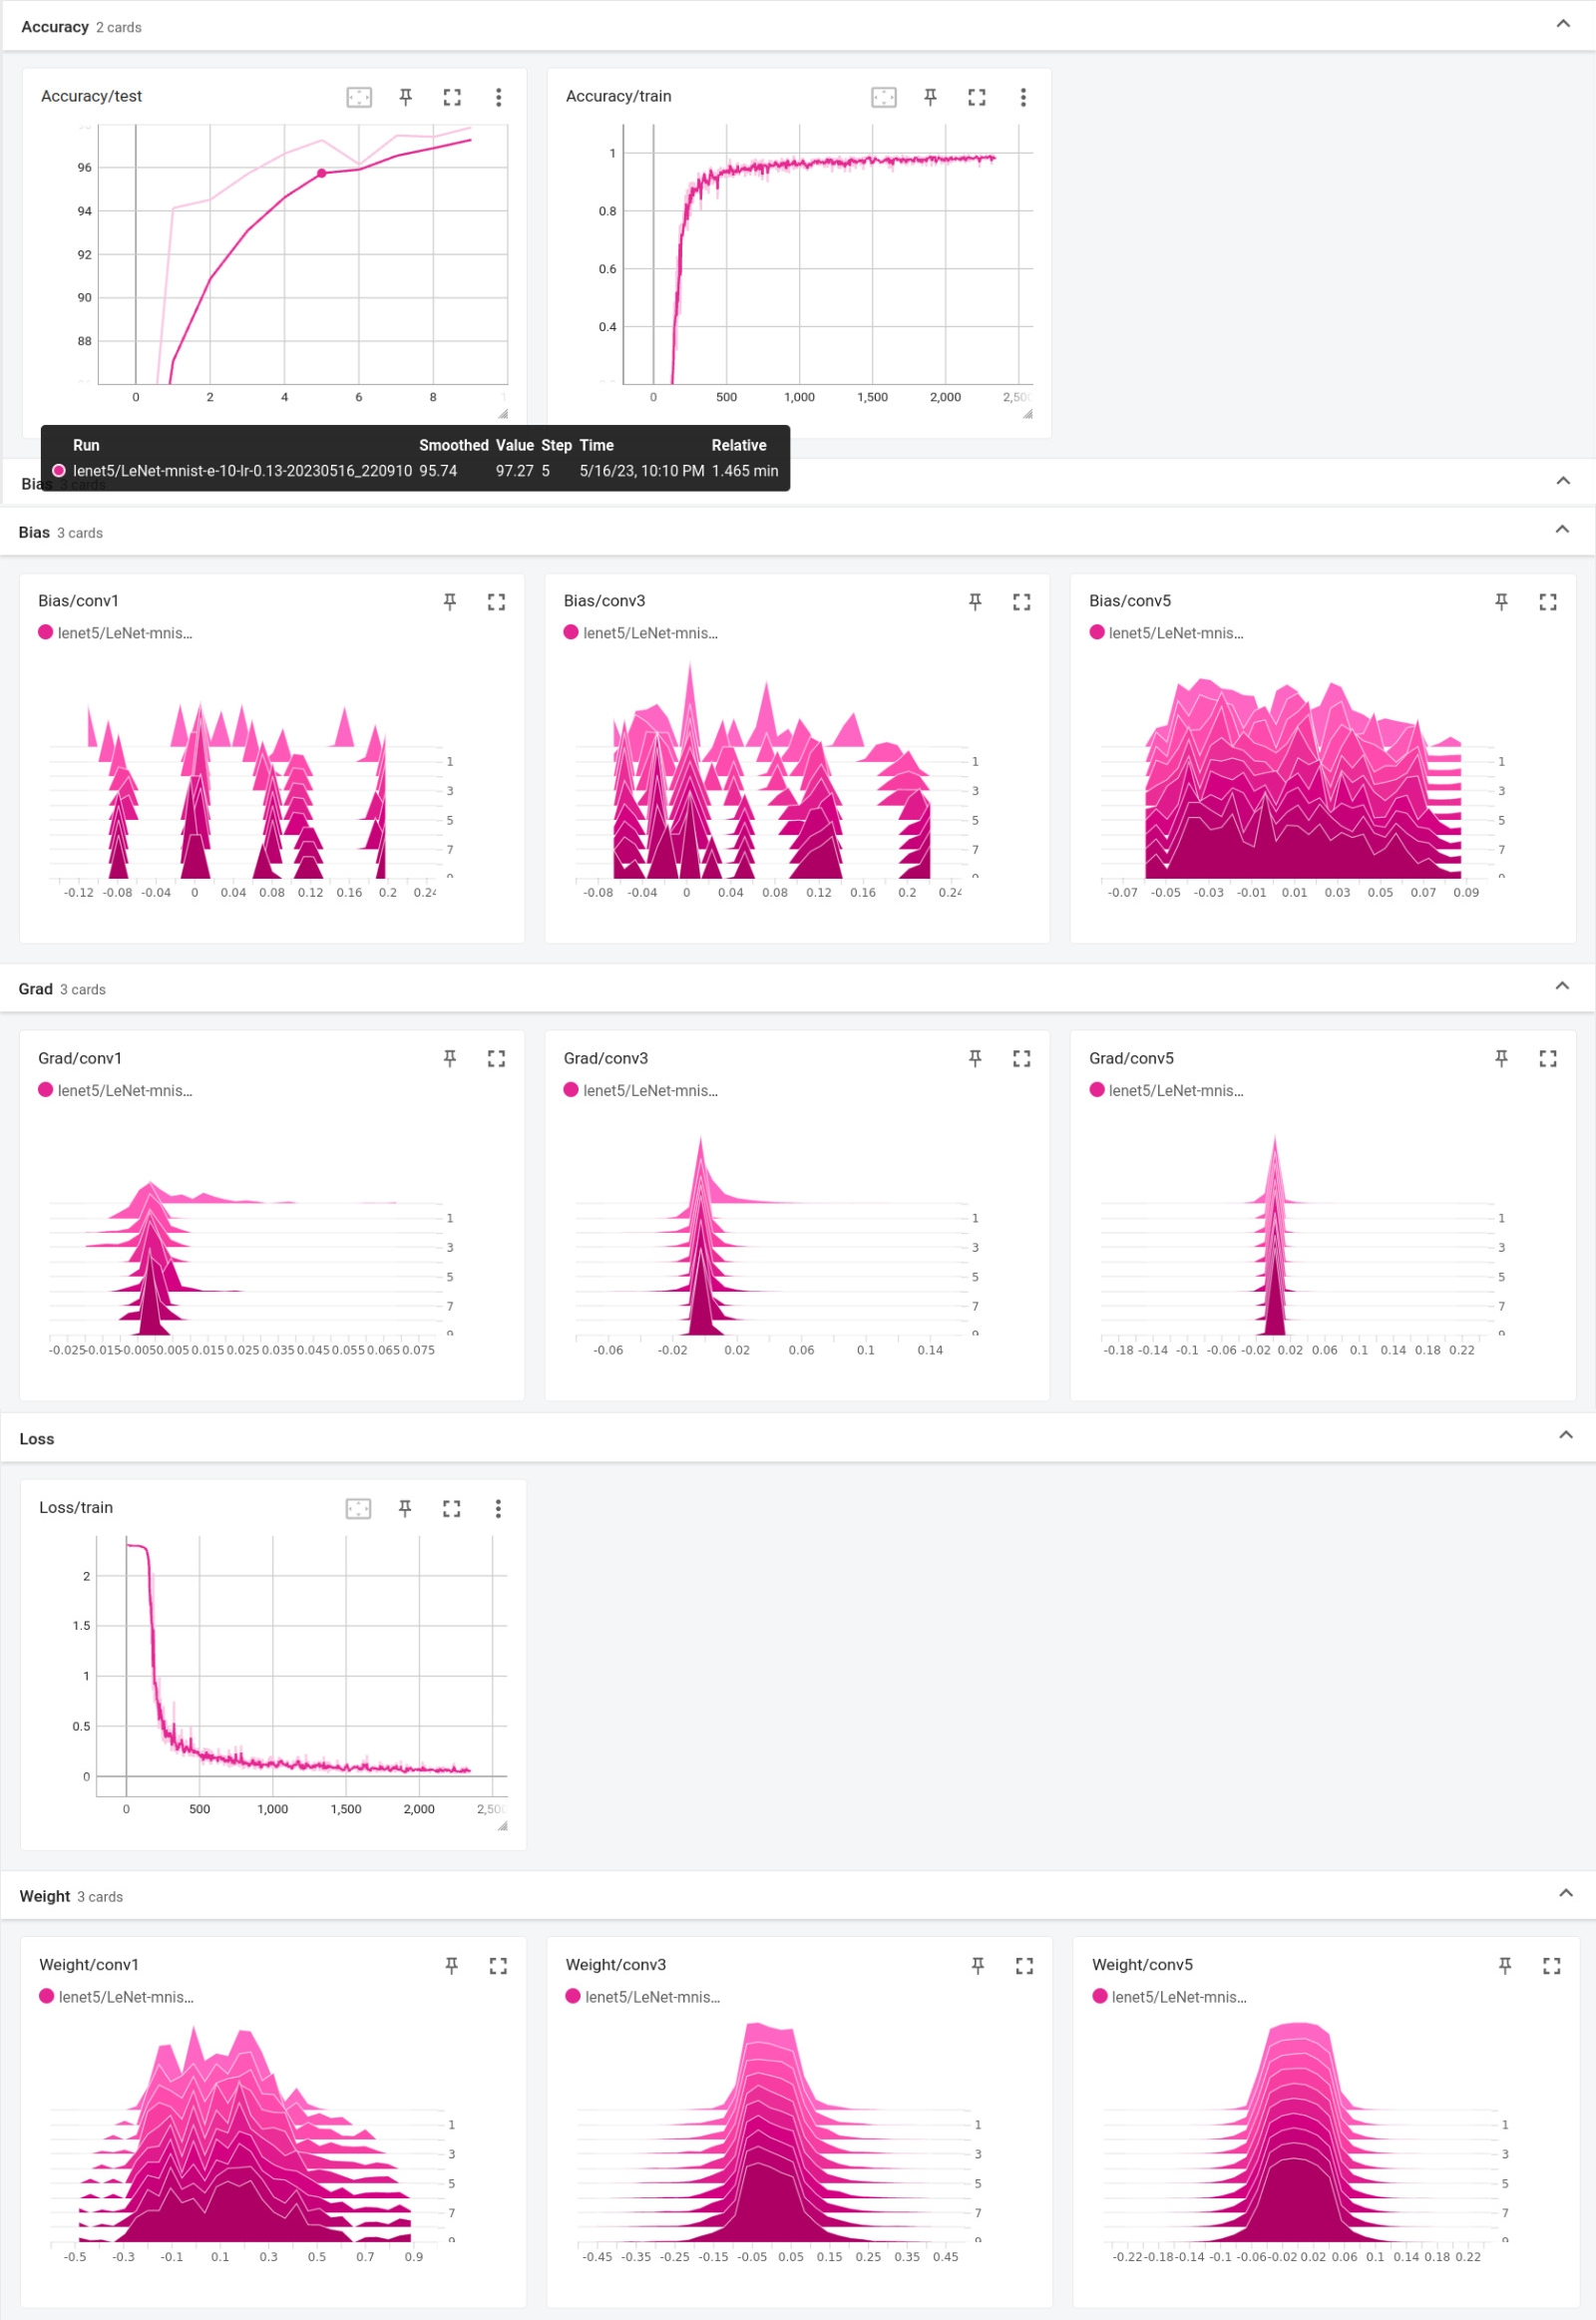

In [12]:
from PIL import Image
print("With ReLu functions and using learning rate of 1.3e-1, we reach 97.42% in epoch 10 ")
image = Image.open("images/relu_mnist.jpg")
image.show()

## Training cifar 10 (sigmoid + tanh)

Running on cuda.
Train samples


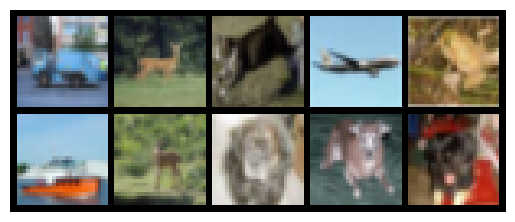

Test samples


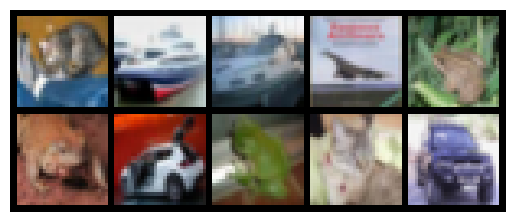

Training epochs...:  10%|█████████████████████▊                                                                                                                                                                                                    | 1/10 [00:11<01:41, 11.24s/it]

Saving Best Model with Accuracy: 10.0000
Epoch:   1 | Accuracy : 10.0000%


Training epochs...:  20%|███████████████████████████████████████████▌                                                                                                                                                                              | 2/10 [00:22<01:29, 11.24s/it]

Saving Best Model with Accuracy: 21.0200
Epoch:   2 | Accuracy : 21.0200%


Training epochs...:  30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3/10 [00:33<01:19, 11.36s/it]

Saving Best Model with Accuracy: 26.3000
Epoch:   3 | Accuracy : 26.3000%


Training epochs...:  40%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 4/10 [00:45<01:08, 11.37s/it]

Saving Best Model with Accuracy: 27.5200
Epoch:   4 | Accuracy : 27.5200%


Training epochs...:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 5/10 [00:57<00:57, 11.49s/it]

Saving Best Model with Accuracy: 34.3500
Epoch:   5 | Accuracy : 34.3500%


Training epochs...:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 6/10 [01:08<00:45, 11.36s/it]

Saving Best Model with Accuracy: 37.9000
Epoch:   6 | Accuracy : 37.9000%


Training epochs...:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7/10 [01:19<00:34, 11.33s/it]

Epoch:   7 | Accuracy : 36.9300%


Training epochs...:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8/10 [01:30<00:22, 11.40s/it]

Saving Best Model with Accuracy: 41.4600
Epoch:   8 | Accuracy : 41.4600%


Training epochs...:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9/10 [01:42<00:11, 11.52s/it]

Epoch:   9 | Accuracy : 37.5300%


Training epochs...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.45s/it]

Saving Best Model with Accuracy: 47.7600
Epoch:  10 | Accuracy : 47.7600%
Model saved in: ap5/models/LeNet5-cifar10-47.76.pkl


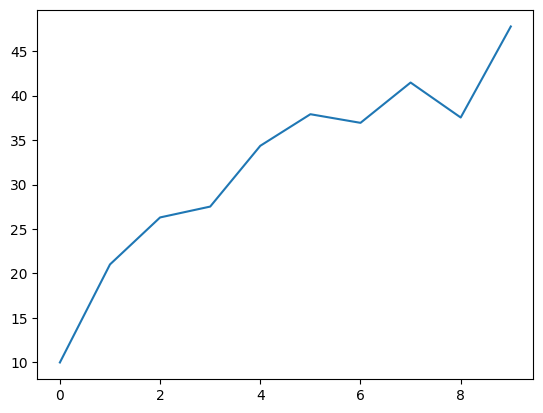

In [81]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
print(f"Running on {my_device.type}.")

epochs = 10
#dataset = 'mnist'
dataset = 'cifar10' 
lr = 1.3e0
lambda_reg = 1e-4

#lr = 1e-1

prefix = 'LeNet-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train( dataset=dataset, epochs=epochs, lr=lr, prefix=prefix , upper_bound=100, device=my_device,
            save=True, debug=False, plot_histograms=True, lambda_reg=lambda_reg )

With sigmoid and tanH functions, we reach 47.76% in epoch 10


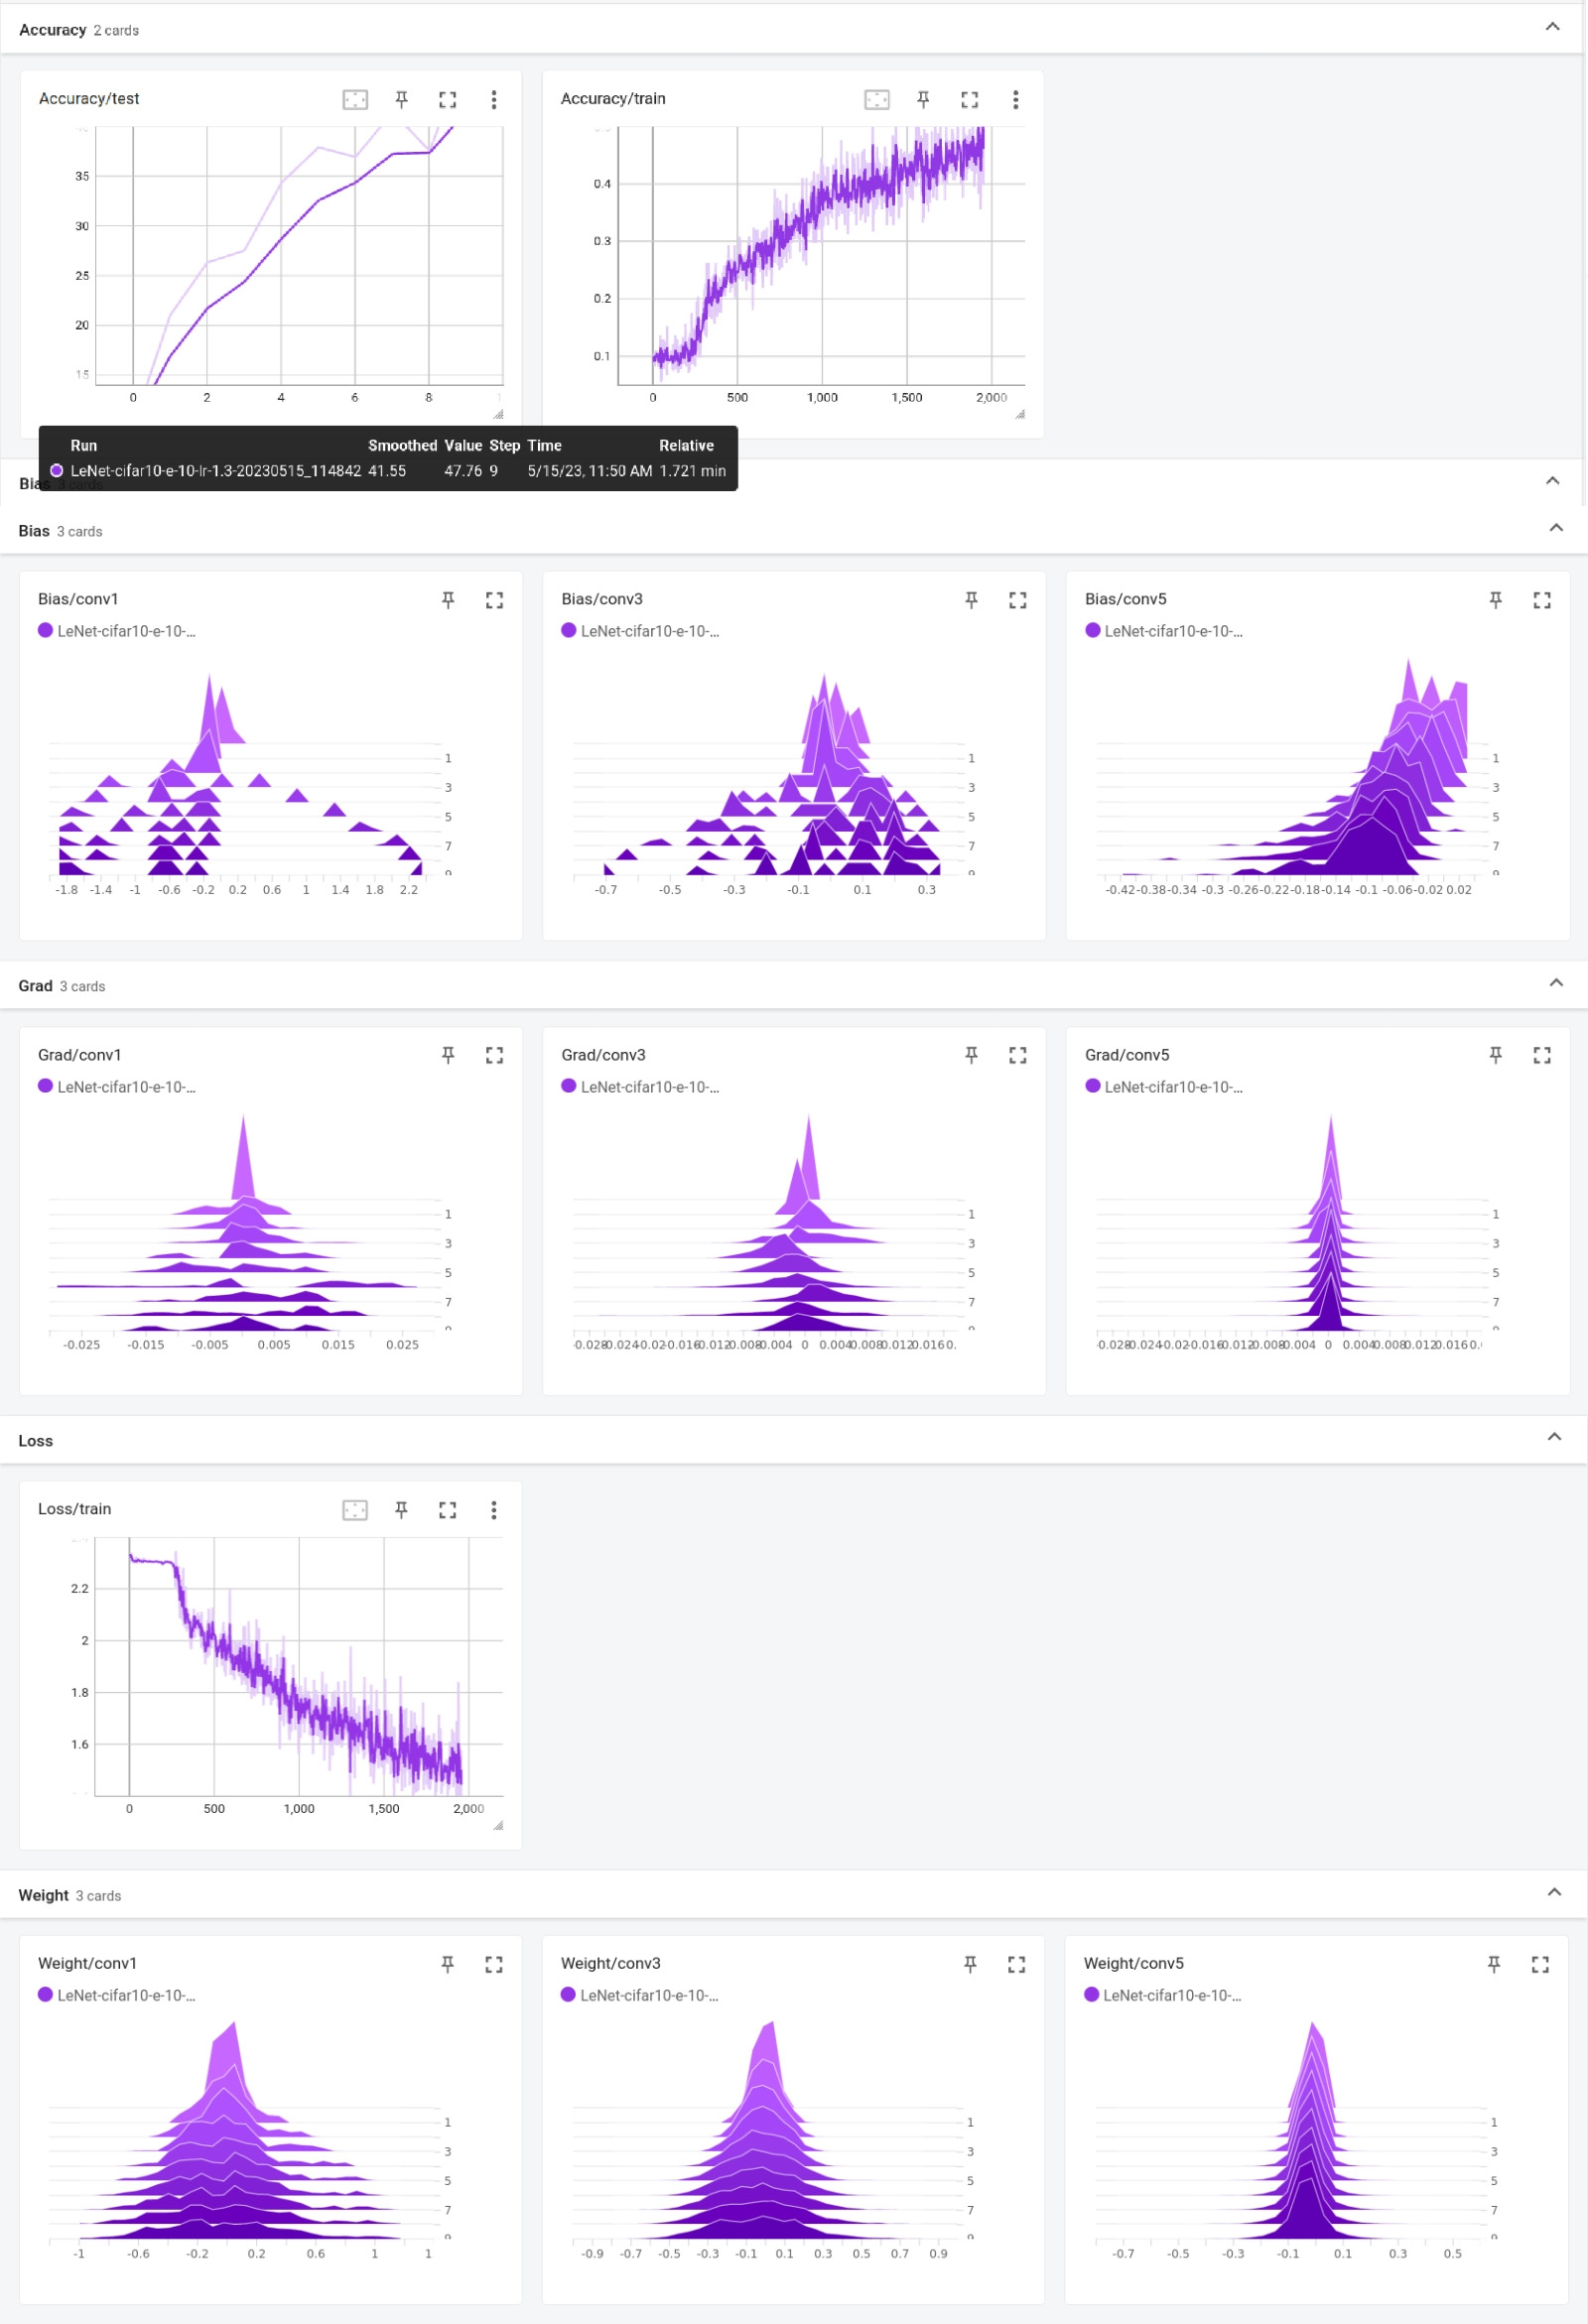

In [84]:
from PIL import Image
print("With sigmoid and tanH functions, we reach 47.76% in epoch 10")
image = Image.open("images/sigmoid_cifar10.jpg")
image.show()

## Training cifar 10 (RELU)

Running on cuda.
Train samples


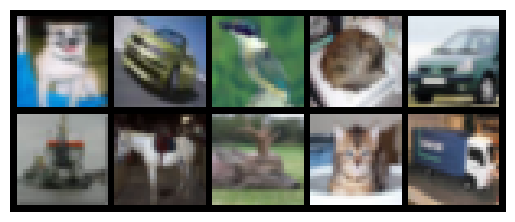

Test samples


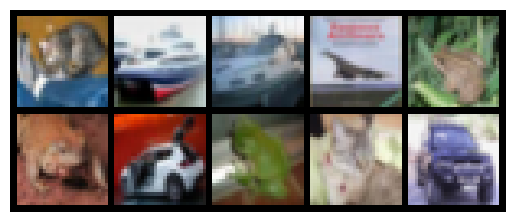

Training epochs...:  10%|█████████████████████▊                                                                                                                                                                                                    | 1/10 [00:11<01:39, 11.11s/it]

Saving Best Model with Accuracy: 29.8300
Epoch:   1 | Accuracy : 29.8300%


Training epochs...:  20%|███████████████████████████████████████████▌                                                                                                                                                                              | 2/10 [00:22<01:28, 11.05s/it]

Saving Best Model with Accuracy: 36.9200
Epoch:   2 | Accuracy : 36.9200%


Training epochs...:  30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 3/10 [00:33<01:17, 11.05s/it]

Saving Best Model with Accuracy: 39.8800
Epoch:   3 | Accuracy : 39.8800%


Training epochs...:  40%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 4/10 [00:44<01:07, 11.30s/it]

Saving Best Model with Accuracy: 44.6800
Epoch:   4 | Accuracy : 44.6800%


Training epochs...:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 5/10 [00:56<00:56, 11.28s/it]

Saving Best Model with Accuracy: 46.9400
Epoch:   5 | Accuracy : 46.9400%


Training epochs...:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 6/10 [01:07<00:45, 11.26s/it]

Saving Best Model with Accuracy: 49.8100
Epoch:   6 | Accuracy : 49.8100%


Training epochs...:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7/10 [01:18<00:33, 11.20s/it]

Epoch:   7 | Accuracy : 49.0000%


Training epochs...:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8/10 [01:29<00:22, 11.13s/it]

Saving Best Model with Accuracy: 51.3900
Epoch:   8 | Accuracy : 51.3900%


Training epochs...:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 9/10 [01:40<00:11, 11.12s/it]

Epoch:   9 | Accuracy : 47.4700%


Training epochs...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.16s/it]

Saving Best Model with Accuracy: 52.8100
Epoch:  10 | Accuracy : 52.8100%
Model saved in: ap5/models/LeNet5-cifar10-52.81.pkl


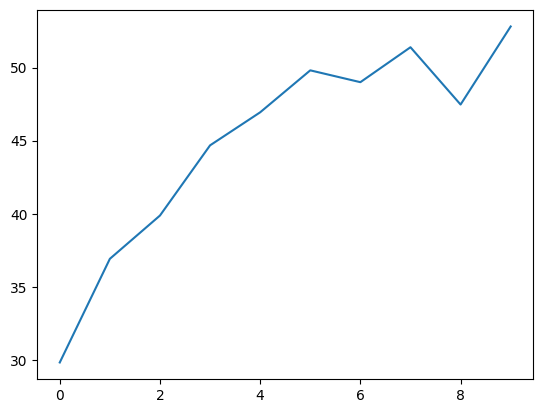

In [13]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
print(f"Running on {my_device.type}.")

epochs = 10
#dataset = 'mnist'
dataset = 'cifar10' 
#lr = 1.3e0
lambda_reg = 1e-4

lr = 1.3e-1

prefix = 'LeNet-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train( dataset=dataset, epochs=epochs, lr=lr, prefix=prefix , upper_bound=100, device=my_device,
            save=True, debug=False, plot_histograms=True, lambda_reg=lambda_reg )

With ReLu functions and using learning rate of 1e-1 , we reach 52.81% in epoch 10 


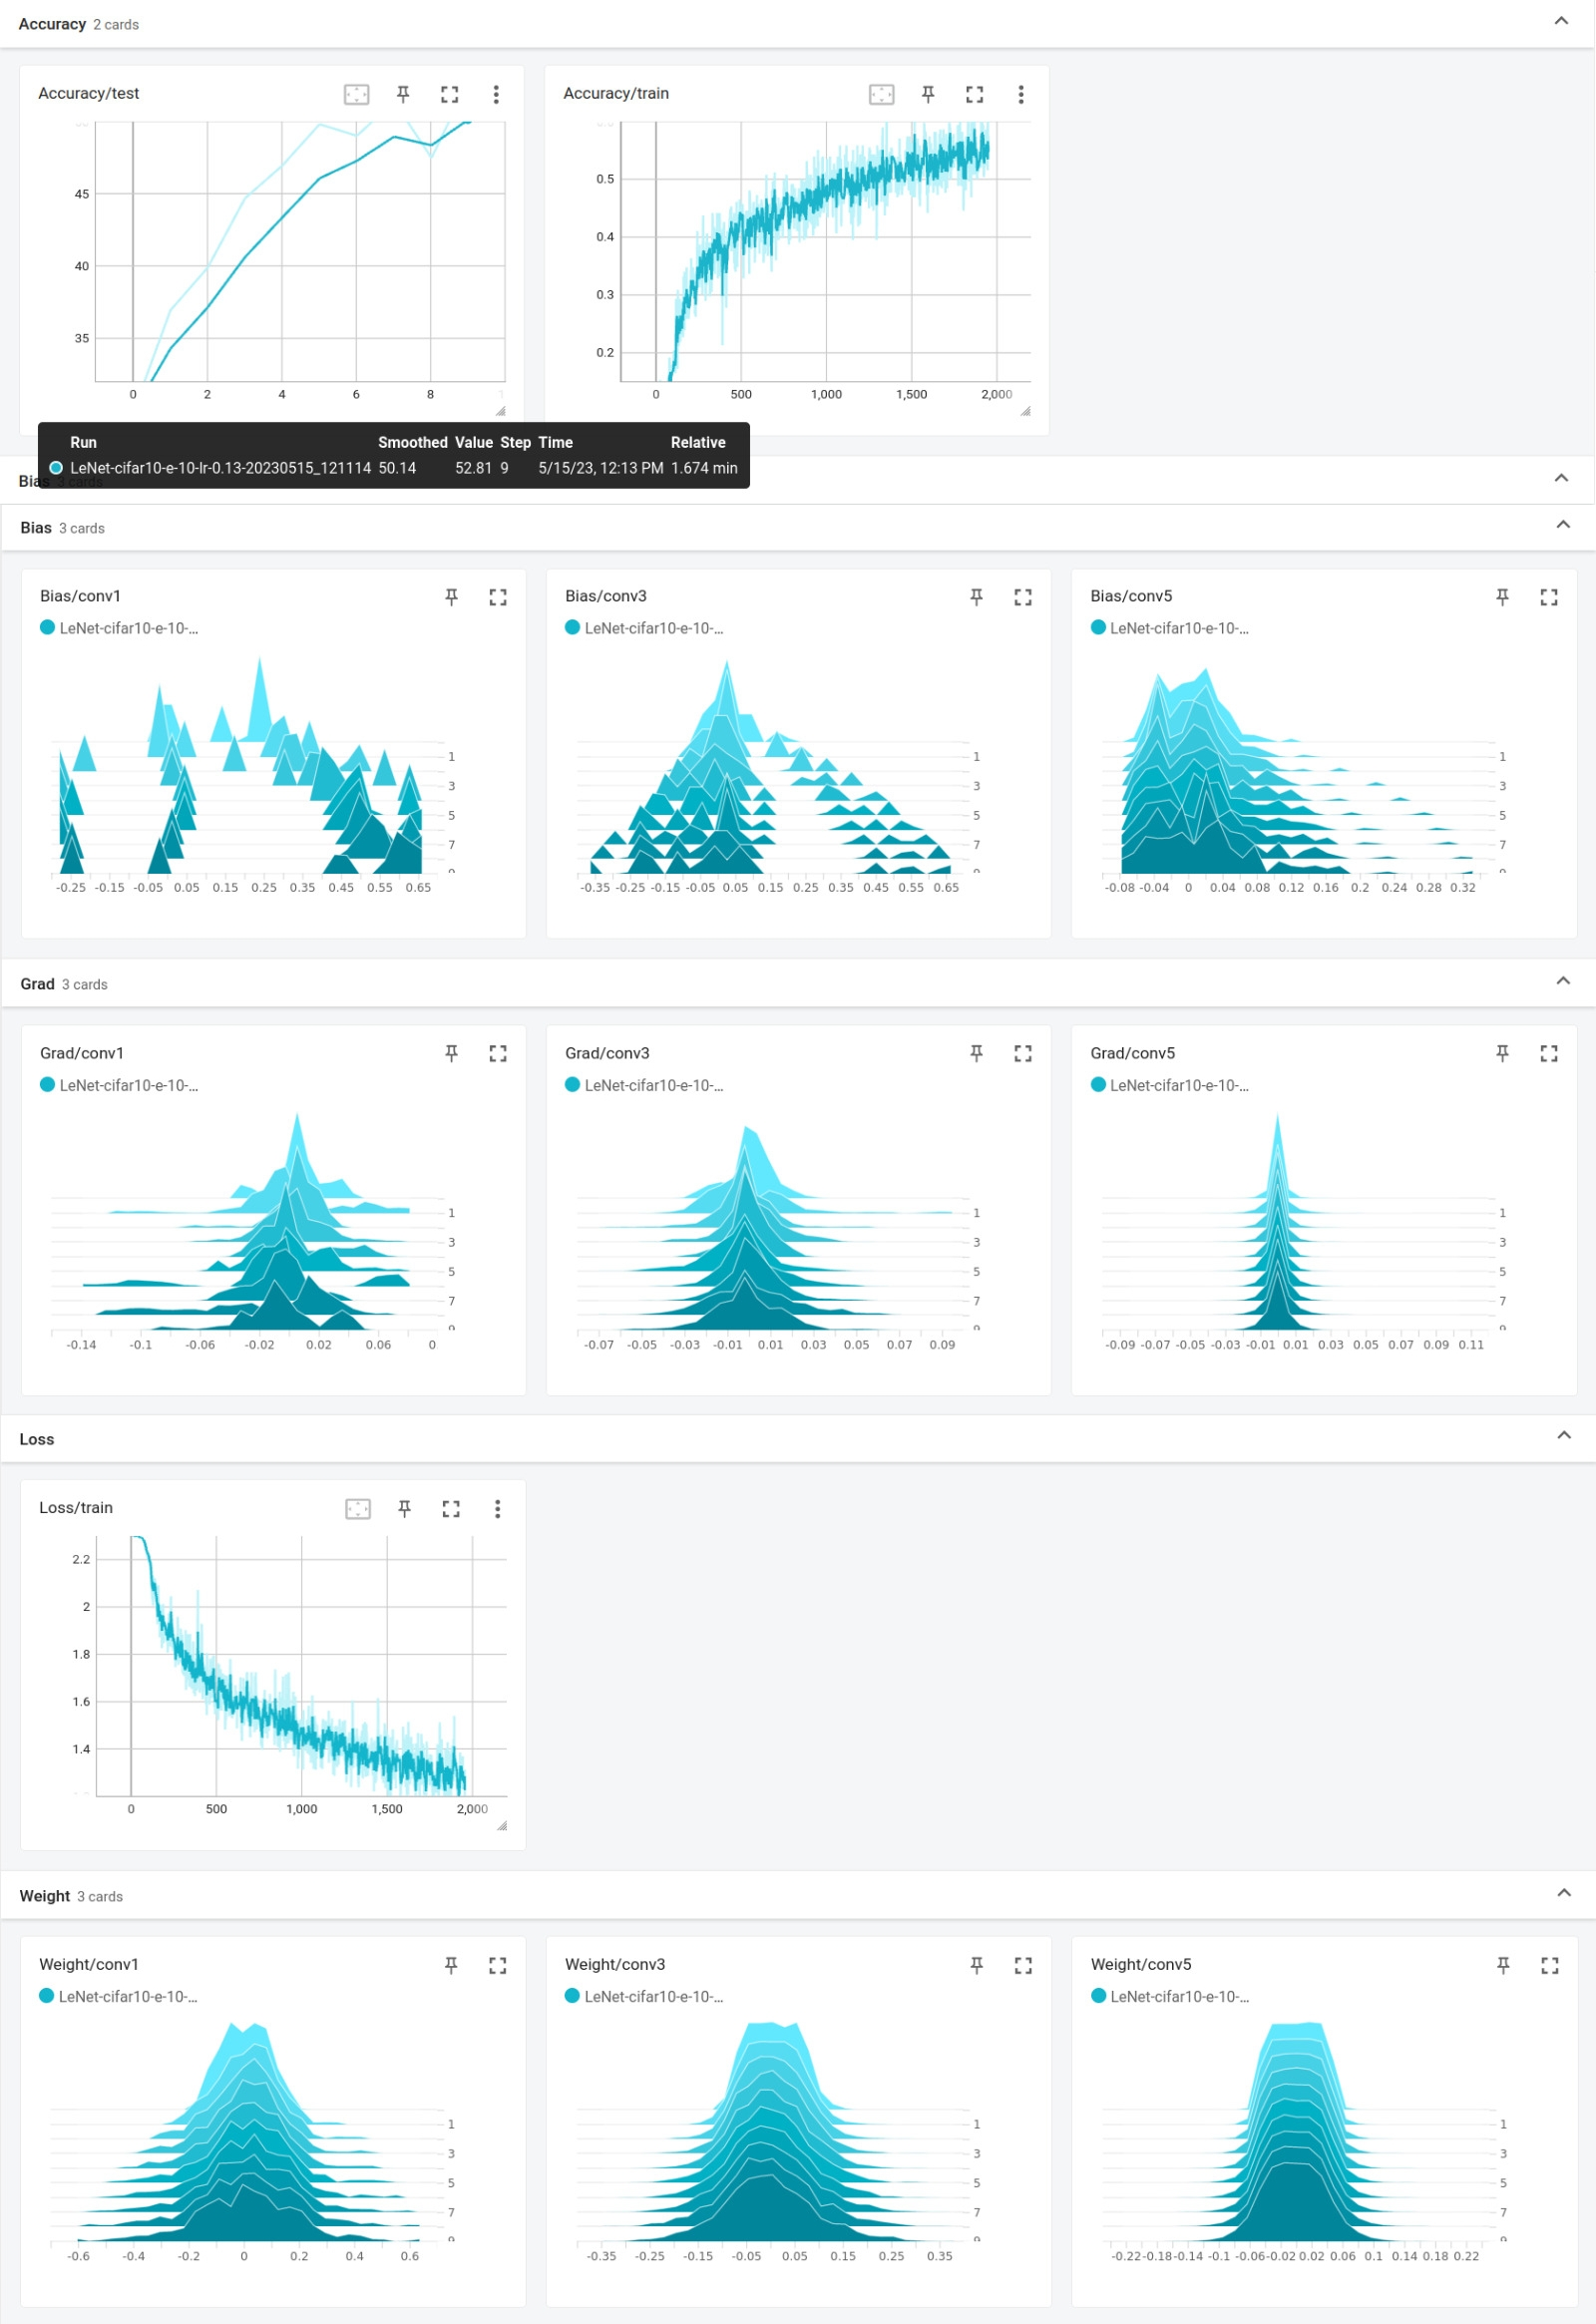

In [15]:
from PIL import Image
print("With ReLu functions and using learning rate of 1e-1 , we reach 52.81% in epoch 10 ")
image = Image.open("images/relu_cifar10.jpg")
image.show()

# Conclusion
In both datasets, incorporating ReLU functions leads to better accuracy within a shorter timeframe. Additionally, the LeNet architecture demonstrates superior performance when applied to the MNIST dataset.